In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import GridSearchCV
%config InlineBackend.figure_format = 'retina'
import operator 
from collections import OrderedDict
from sklearn import svm
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import math
%matplotlib inline
from sklearn.utils import shuffle
import scipy.io as sio
plt.rcParams['figure.figsize'] = 8,8
from scipy.io import arff
import pandas as pd
from numpy import random
from sklearn import metrics
from sklearn.model_selection import validation_curve
from sklearn.linear_model import Ridge
from sklearn import linear_model, datasets
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import warnings

In [2]:
def shuffle(dataset):
    X_and_Y = dataset # Load data from file.
    np.random.shuffle(X_and_Y)   # Shuffle the data.
    X = X_and_Y[:, 0:-1]         # First column to second last column: Features (numerical values) 
    Y = X_and_Y[:, -1]           # Last column: Labels (0 or 1)
    return X, Y

In [3]:
# 2) Split the dataset into 2 parts: 
#    (a) Training set + Validation set  (80% of all data points)
#    (b) Test set                       (20% of all data points)

def split_dataset(percentage,X,Y):
    X_train_val = X[:int(percentage*len(X))] # Get features from train + val set.
    X_test      = X[int(percentage*len(X)):] # Get features from test set.     
    Y_train_val = Y[:int(percentage*len(Y))] # Get labels from train + val set.
    Y_test      = Y[int(percentage*len(Y)):] # Get labels from test set.
    print(X_train_val.shape, X_test.shape, Y_train_val.shape, Y_test.shape)
    return X_train_val, X_test, Y_train_val, Y_test

In [4]:
def create_partition_trial(dataset, train_percent):
    X,Y = shuffle(dataset)
    print(X.shape, Y.shape)      # Check the shapes.
    X_train, X_test, Y_train, Y_test = split_dataset(train_percent,X,Y)
    return X_train, X_test, Y_train, Y_test

In [5]:
warnings.filterwarnings("ignore")

In [67]:
#For each dataset, run this 9 times (3 trials x 3 partitions)
def run_through_algorithms(X_train_val, X_test, Y_train_val, Y_test):

    dtc_tr, dtc_v, dtc_ts, dtc_f = decision_tree_classifier(X_train_val, X_test, Y_train_val, Y_test)
    svm_tr,svm_v, svm_ts, svm_f = SVM_classifier_RBF(X_train_val, X_test, Y_train_val, Y_test)
    knn_tr, knn_v, knn_ts, knn_f= KNN_classifier(X_train_val, X_test, Y_train_val, Y_test)   
    rf_tr, rf_v, rf_ts, rf_f = random_forest_classifier(X_train_val, X_test, Y_train_val, Y_test)
    ada_tr, ada_v, ada_ts, ada_f = adaboost_dtc_classifier(X_train_val, X_test, Y_train_val, Y_test)        
    bag_tr, bag_v, bag_ts, bag_f = bagging_classifier(X_train_val, X_test, Y_train_val, Y_test)
    
    
    return dtc_tr, dtc_v, dtc_ts, dtc_f, svm_tr,svm_v, svm_ts, svm_f, knn_tr, knn_v, knn_ts, knn_f,  rf_tr, rf_v, rf_ts, rf_f, ada_tr, ada_v, ada_ts, ada_f, bag_tr, bag_v, bag_ts, bag_f


## Classifiers

In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

def adaboost_dtc_classifier(X_train_val, X_test, Y_train_val, Y_test):

    print("ADABOOST CLASSIFIER w/ DTC Base Estimator")
    
    #Create both classifiers
    dtc = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "balanced")
    adaboost = AdaBoostClassifier(base_estimator = dtc)
    
    #Perform Grid Search
    param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
                  'base_estimator__max_depth': [1, 3, 5, 7],
                  "n_estimators": [25, 50, 75, 100]
                 }
    grid = GridSearchCV(adaboost, param_grid=param_grid,cv = 5, scoring = 'roc_auc')
    grid.fit(X_train_val,Y_train_val)


    #Find Maximum Validation Accuracy
    val_acc = grid.cv_results_['mean_test_score']
    maximum_val = val_acc[0]
    for i in val_acc:
        if maximum_val < i:
            maximum_val = i


    #Find Training Accuracy 
    Y_train_pred_class = grid.predict(X_train_val)
    train_acc = (np.sum((Y_train_pred_class) == Y_train_val) / len(Y_train_val))

    #Find Testing Accuracy
    Y_pred_class = grid.predict(X_test)
    test_acc = (np.sum((Y_pred_class) == Y_test) / len(Y_test))


    Y_pred_class = grid.predict(X_test)

    print("Best parameters based on validation set:")
    print(grid.best_params_)
    print()


    f_score = f1_score(Y_test, Y_pred_class, average='macro')  
    print("f-score = {}".format(f_score))
    print("Train Accuracy for ADABOOST w/ DTC Base Estimator = {} ".format(train_acc))
    print("Val Accuracy for ADABOOST w/ DTC Base Estimator = {} ".format(maximum_val))
    print("Test Accuracy for ADABOOST w/ DTC Base Estimator = {} ".format(test_acc))
    print()
    return train_acc, round(maximum_val,3), test_acc, f_score
    

In [54]:
def decision_tree_classifier(X_train_val, X_test, Y_train_val, Y_test):

    print("DECISION TREE CLASSIFIER")
    
    #Fit Data to Decision Tree Classifier 
    dtc = tree.DecisionTreeClassifier(criterion='entropy')
    dtc = dtc.fit(X_train_val, Y_train_val)

    #Perform Grid Search
    D_list=[1,2,3,4,5]
    parameters={'max_depth': D_list}
    grid = GridSearchCV(dtc, param_grid = parameters, cv=5, scoring='accuracy')
    grid.fit(X_train_val, Y_train_val)

    
    #Find Maximum Validation Accuracy
    val_acc = grid.cv_results_['mean_test_score'].reshape(5,1)
    draw_heatmap_linear(val_acc, 'val accuracy', D_list)
    maximum_val = val_acc[0][0]
    for i in val_acc:
        if maximum_val < i[0]:
             maximum_val = i[0]

    #Best Features    
    max_depth = grid.best_params_['max_depth']
    print("Best parameters based on validation set:")
    print(grid.best_params_)
    print()
        
    #Fit Data with Classifier holding maximum hyperparameters w.r.t validation set    
    dtc = tree.DecisionTreeClassifier(criterion='entropy', max_depth = max_depth)
    dtc.fit(X_train_val, Y_train_val)

    
    #Find Training Accuracy 
    Y_train_pred_class = dtc.predict(X_train_val)
    train_acc = (np.sum((Y_train_pred_class) == Y_train_val) / len(Y_train_val))

    #Find Testing Accuracy
    Y_pred_class = dtc.predict(X_test)
    test_acc = (np.sum((Y_pred_class) == Y_test) / len(Y_test))
    

    #Metrics including f-score and 3 accuracies                
    f_score = f1_score(Y_test, Y_pred_class, average='macro')  
#     print("f-score = {}".format(f_score))
#     print("Train Accuracy for Decision Tree = {} ".format(train_acc))
#     print("Val Accuracy for Decision Tree = {} ".format(maximum_val))
#     print("Test Accuracy for Decision Tree = {} ".format(test_acc))
    print()
    return train_acc, round(maximum_val,3), test_acc, f_score

In [55]:
# 4) Draw heatmaps for result of grid search and find 
#    optimal D for validation set.
def draw_heatmap_linear(acc, acc_desc, depth_list):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=depth_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='depth')
    plt.title(acc_desc + ' w.r.t depth')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()

In [82]:
def random_forest_classifier(X_train_val, X_test, Y_train_val, Y_test):
    # 3) Perform grid search for best D using sklearn
    print()
    print()
    print("RANDOM FOREST CLASSIFIER")
    
    #Fit Data to Random Forest Classifier
    rfc = RandomForestClassifier()
    rfc = rfc.fit(X_train_val, Y_train_val)

    #Perform Grid Search
    param_grid = {'max_depth': [80, 90, 100, 110], 'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5]}
    grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
    grid.fit(X_train_val, Y_train_val)
    
    #Find Maximum Validation Accuracy
    val_acc = grid.cv_results_['mean_test_score']
    maximum_val = val_acc[0]
    for i in val_acc:
        if maximum_val < i:
             maximum_val = i
    
    #Best Features
    max_depth = grid.best_params_['max_depth']
    max_features = grid.best_params_['max_features']
    min_samples_leaf = grid.best_params_['min_samples_leaf']
    print("Best parameters based on validation set:")
    print(grid.best_params_)
    print()
    
    
    
    #Fit Data with Classifier holding maximum hyperparameters w.r.t validation set
    rfc = RandomForestClassifier(max_depth = max_depth, max_features = max_features,
                                 min_samples_leaf = min_samples_leaf)
    rfc = rfc.fit(X_train_val, Y_train_val)
    
    #Find Training Accuracy 
    Y_train_pred_class = rfc.predict(X_train_val)
    train_acc = (np.sum((Y_train_pred_class) == Y_train_val) / len(Y_train_val))

    #Find Testing Accuracy
    Y_pred_class = rfc.predict(X_test)
    test_acc = (np.sum((Y_pred_class) == Y_test) / len(Y_test))
                
    #Metrics including f-score and 3 accuracies
    f_score = f1_score(Y_test, Y_pred_class, average='macro')  

    print()
    return train_acc, round(maximum_val,3) , test_acc, f_score


In [83]:
def SVM_classifier_RBF(X_train_val, X_test, Y_train_val, Y_test):

    print()
    print()
    print("SVM CLASSIFIER")
    
    #Fit Data to SVM
    classifier = svm.SVC(kernel = 'rbf')
    classifier = classifier.fit(X_train_val, Y_train_val)

    #Perform Grid Search
    C_list     = [10**(-3), 10**(-2), 10**(-1), 10**1, 10**2, 10**3]
    gamma_list = [10**(-9), 10**(-7), 10**(-5), 10**(-3), 10**(-1), 10]
    grid = GridSearchCV(classifier, [{'C':C_list,'gamma':gamma_list}], n_jobs = -1, cv = 5, return_train_score= True, iid = True)
    grid.fit(X_train_val, Y_train_val)
    
    
    #Find Maximum Validation Accuracy
    val_acc   = grid.cv_results_['mean_test_score'].reshape(6,6)
    draw_heatmap_RBF(val_acc, 'val accuracy',gamma_list, C_list)
    maximum_val = val_acc[0][0]
    n=0
    for i in val_acc:
        for i in val_acc:
            if maximum_val < i[n]:
                 maximum_val = i[n]
        n=n+1
    
    #Best Features
    C = grid.best_params_['C']
    gamma = grid.best_params_['gamma']
    print("Best parameters based on validation set:")
    print(grid.best_params_)
    print()
        
    #Fit Data with Classifier holding maximum hyperparameters w.r.t validation set
    classifier = svm.SVC(kernel = 'rbf', C= C, gamma=gamma)
    classifier.fit(X_train_val, Y_train_val)
    
    #Find Training Accuracy 
    Y_train_pred_class = classifier.predict(X_train_val)
    train_acc = (np.sum((Y_train_pred_class) == Y_train_val) / len(Y_train_val))

    #Find Testing Accuracy
    Y_pred_class = classifier.predict(X_test)
    test_acc = (np.sum((Y_pred_class) == Y_test) / len(Y_test))
                
        
    #Metrics including f-score and 3 accuracies
    f_score = f1_score(Y_test, Y_pred_class, average='macro')  

    print()
    return train_acc, round(maximum_val,3),test_acc, f_score

In [84]:
def draw_heatmap_RBF(acc, acc_desc, gamma_list, C_list):
    plt.figure(figsize = (5,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', 
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = '$\gamma$', ylabel='$C$')
    plt.title(acc_desc + ' w.r.t $C$ and $\gamma$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()

In [85]:
def KNN_classifier(X_train_val, X_test, Y_train_val, Y_test):   
    
    print()
    print()
    print("KNN CLASSIFIER")

    #Fit Data to KNN
    knn = KNeighborsClassifier()
    knn.fit(X_train_val, Y_train_val)
    
    #Perform Grid Search
    parameters = {'n_neighbors':[3,5,7, 9]}

    grid = GridSearchCV(estimator=knn, param_grid=parameters, cv=3)
    grid.fit(X_train_val, Y_train_val)
    
      
    #Find Maximum Validation Accuracy
    val_acc = grid.best_score_
    
    #Best Features
    n_neighbors = grid.best_params_['n_neighbors']
    print("Best parameters based on validation set:")
    print(grid.best_params_)
    print()


    #Fit Data with Classifier holding maximum hyperparameters w.r.t validation set
    knn = KNeighborsClassifier(n_neighbors = n_neighbors)
    knn = knn.fit(X_train_val, Y_train_val)
    
    #Find Training Accuracy 
    Y_train_pred_class = knn.predict(X_train_val)
    train_acc = (np.sum((Y_train_pred_class) == Y_train_val) / len(Y_train_val))

    #Find Testing Accuracy
    Y_pred_class = knn.predict(X_test)
    test_acc = (np.sum((Y_pred_class) == Y_test) / len(Y_test))
                
    #Metrics including f-score and 3 accuracies
    f_score = f1_score(Y_test, Y_pred_class, average='macro')  

    print()
    return train_acc, round(val_acc,3), test_acc, f_score

In [86]:
def bagging_classifier(X_train_val, X_test, Y_train_val, Y_test):
    print()
    print()
    print("BAGGING CLASSIFIER")
    
    bagging_clf = BaggingClassifier(tree.DecisionTreeClassifier(random_state=1))
    bagging_clf.fit(X_train_val, Y_train_val)

    n_estimators = [5, 10, 15, 20, 25]

    grid = GridSearchCV(bagging_clf,[{'n_estimators':n_estimators}],cv=5, scoring='accuracy',return_train_score=True)
    grid.fit(X_train_val, Y_train_val)


    plt.plot(n_estimators, grid.cv_results_['mean_train_score'], color='g')
    plt.plot(n_estimators, grid.cv_results_['mean_test_score'], color='orange')
    plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
    plt.xlabel('n_estimators')
    plt.ylabel('Accuracy')
    plt.title('Training/Validation Curves')
    plt.show()
    test_acc=grid.score(X_test, Y_test)
    Y_pred_class = bagging_clf.predict(X_test)
    train_acc=grid.score(X_train_val,Y_train_val)
    val_acc = grid.best_score_

    #Metrics including f-score and 3 accuracies
    f_score = f1_score(Y_test, Y_pred_class, average='macro')  

    return train_acc,round(val_acc,3),test_acc, f_score

In [87]:
#DATASET1 11500 rows reduced to 5000 rows
from sklearn.preprocessing import MinMaxScaler

seizure = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/00388/data.csv")
seizure = seizure.drop(columns = ["Unnamed: 0"])
seizure = seizure[:5000] 
seizure["y"][0]
n=0
for i in seizure["y"]:
    if i != 1:
        seizure["y"][n] = 0
    n=n+1
seizure_numpy = seizure
seizure_numpy
scaler = MinMaxScaler()
seizure_numpy = scaler.fit_transform(seizure_numpy)


In [88]:
first_2080_trial = create_partition_trial(seizure_numpy, 0.20)

(5000, 178) (5000,)
(1000, 178) (4000, 178) (1000,) (4000,)


In [89]:
#partitions data into the three partitions, three trials
f_2080, s_2080, t_2080, f_5050, s_5050, t_5050, f_8020, s_8020, t_8020 = [create_partition_trial(seizure_numpy, 0.20) for i in range(9)]

(5000, 178) (5000,)
(1000, 178) (4000, 178) (1000,) (4000,)
(5000, 178) (5000,)
(1000, 178) (4000, 178) (1000,) (4000,)
(5000, 178) (5000,)
(1000, 178) (4000, 178) (1000,) (4000,)
(5000, 178) (5000,)
(1000, 178) (4000, 178) (1000,) (4000,)
(5000, 178) (5000,)
(1000, 178) (4000, 178) (1000,) (4000,)
(5000, 178) (5000,)
(1000, 178) (4000, 178) (1000,) (4000,)
(5000, 178) (5000,)
(1000, 178) (4000, 178) (1000,) (4000,)
(5000, 178) (5000,)
(1000, 178) (4000, 178) (1000,) (4000,)
(5000, 178) (5000,)
(1000, 178) (4000, 178) (1000,) (4000,)


In [90]:
names = ['DT', 'SVM', 'KNN', 'RF', 'ADA', 'BAG']

In [91]:
#[[first_trial_scores[i], second_trial_scores[i], third_trial_scores[i]] for i in range(12) if i%2==0]

1st trial, 20/80 split:
DECISION TREE CLASSIFIER


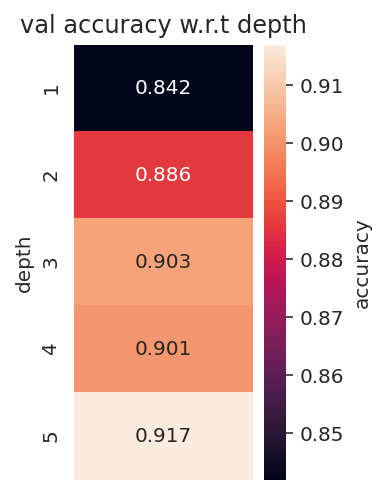

Best parameters based on validation set:
{'max_depth': 5}




SVM CLASSIFIER


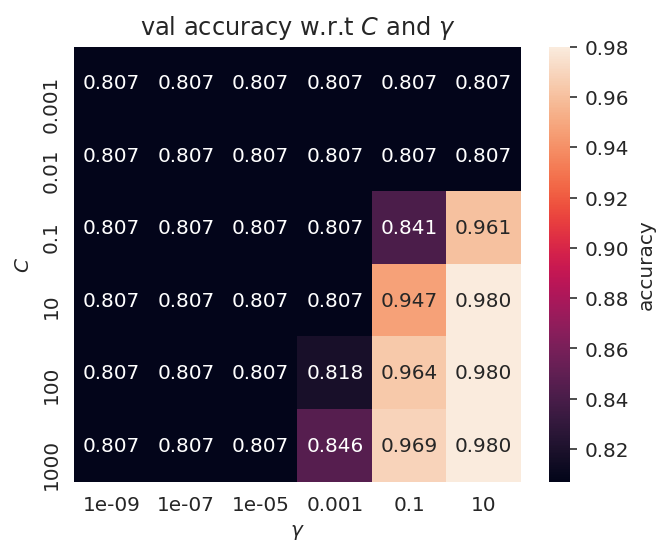

Best parameters based on validation set:
{'C': 10, 'gamma': 10}

f-score = 0.9411677127268756



KNN CLASSIFIER
Best parameters based on validation set:
{'n_neighbors': 3}




RANDOM FOREST CLASSIFIER
Best parameters based on validation set:
{'max_depth': 110, 'max_features': 3, 'min_samples_leaf': 3}


ADABOOST CLASSIFIER w/ DTC Base Estimator
Best parameters based on validation set:
{'base_estimator__criterion': 'entropy', 'base_estimator__max_depth': 7, 'n_estimators': 100}

f-score = 0.926883596073649
Train Accuracy for ADABOOST w/ DTC Base Estimator = 1.0 
Val Accuracy for ADABOOST w/ DTC Base Estimator = 0.9958413934005087 
Test Accuracy for ADABOOST w/ DTC Base Estimator = 0.95625 



BAGGING CLASSIFIER


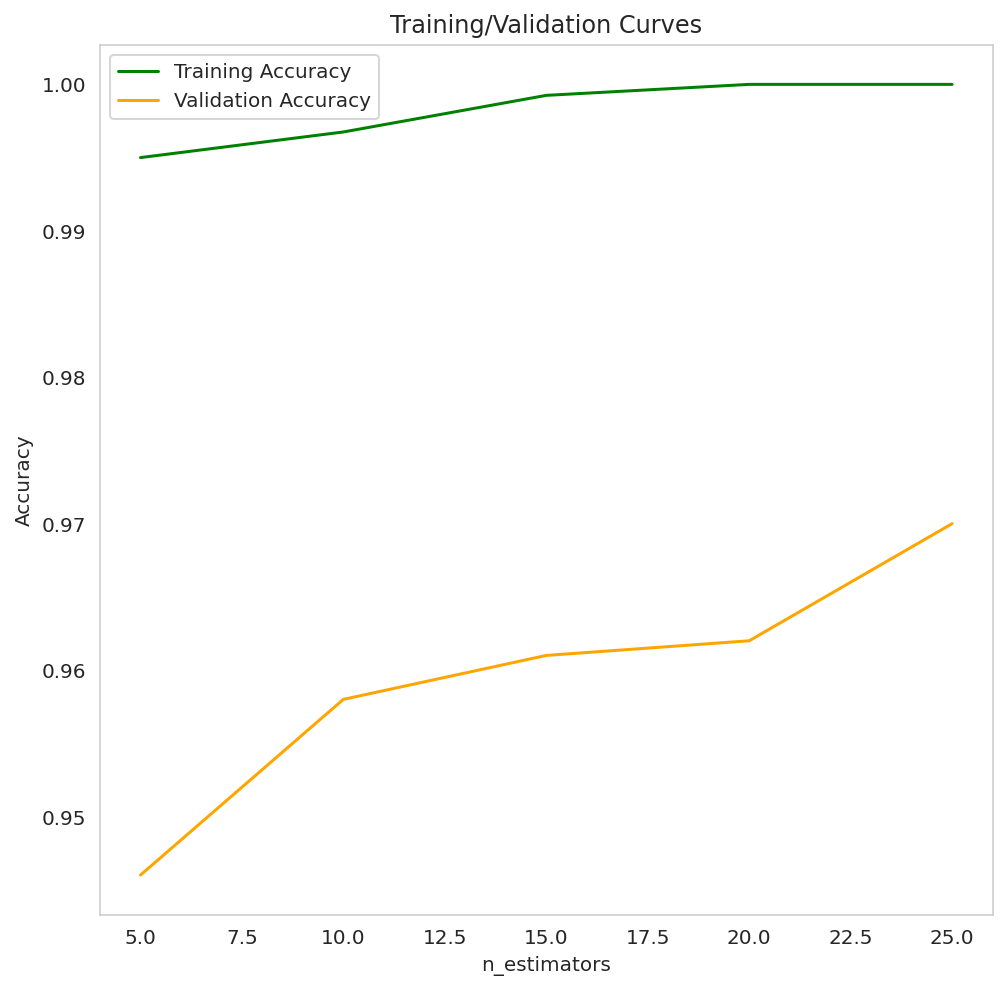


2nd trial, 20/80 split:
DECISION TREE CLASSIFIER


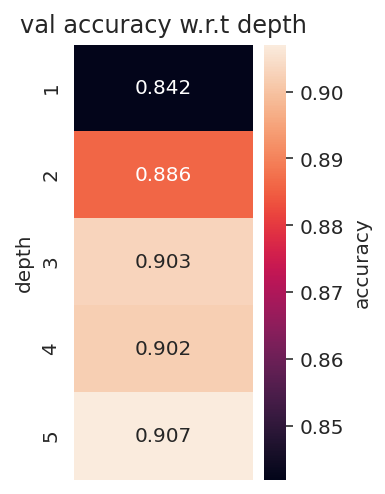

Best parameters based on validation set:
{'max_depth': 5}




SVM CLASSIFIER


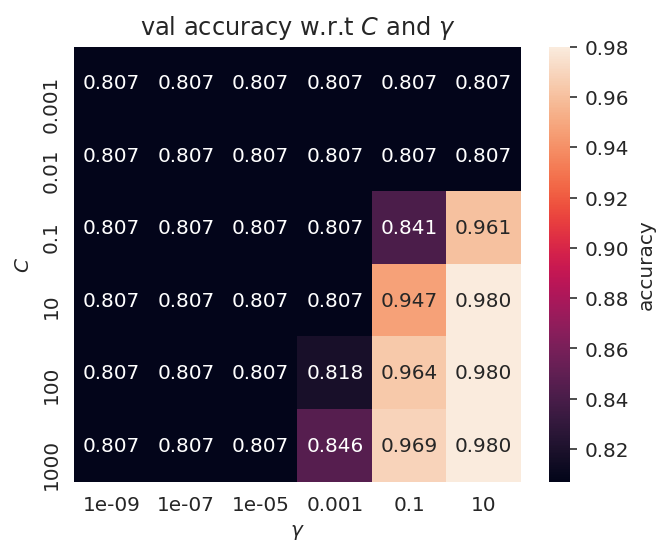

Best parameters based on validation set:
{'C': 10, 'gamma': 10}

f-score = 0.9411677127268756



KNN CLASSIFIER
Best parameters based on validation set:
{'n_neighbors': 3}




RANDOM FOREST CLASSIFIER
Best parameters based on validation set:
{'max_depth': 100, 'max_features': 2, 'min_samples_leaf': 3}


ADABOOST CLASSIFIER w/ DTC Base Estimator
Best parameters based on validation set:
{'base_estimator__criterion': 'entropy', 'base_estimator__max_depth': 7, 'n_estimators': 100}

f-score = 0.9271149092804483
Train Accuracy for ADABOOST w/ DTC Base Estimator = 1.0 
Val Accuracy for ADABOOST w/ DTC Base Estimator = 0.9963210857566311 
Test Accuracy for ADABOOST w/ DTC Base Estimator = 0.95625 



BAGGING CLASSIFIER


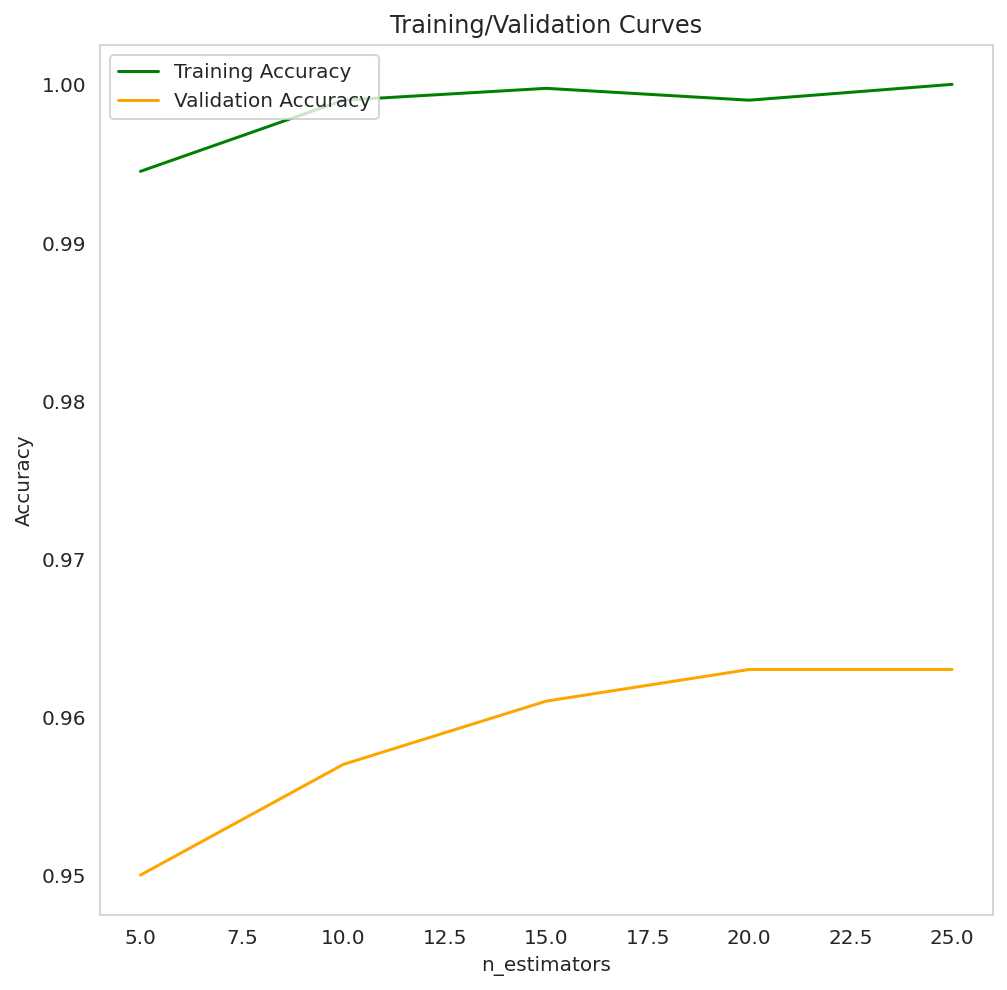


3rd trial, 20/80 split:
DECISION TREE CLASSIFIER


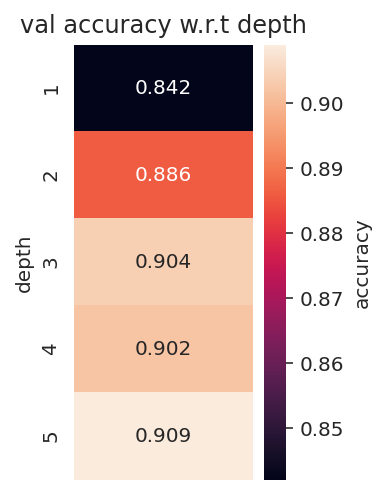

Best parameters based on validation set:
{'max_depth': 5}




SVM CLASSIFIER


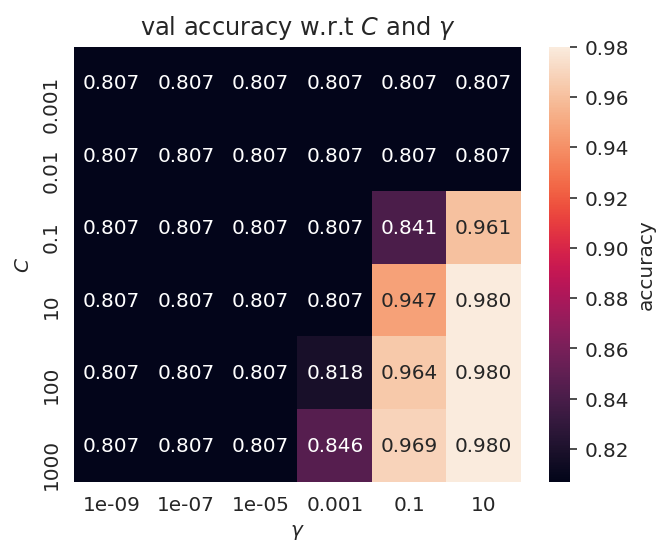

Best parameters based on validation set:
{'C': 10, 'gamma': 10}

f-score = 0.9411677127268756



KNN CLASSIFIER
Best parameters based on validation set:
{'n_neighbors': 3}




RANDOM FOREST CLASSIFIER
Best parameters based on validation set:
{'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 4}


ADABOOST CLASSIFIER w/ DTC Base Estimator
Best parameters based on validation set:
{'base_estimator__criterion': 'entropy', 'base_estimator__max_depth': 7, 'n_estimators': 100}

f-score = 0.9231640060115813
Train Accuracy for ADABOOST w/ DTC Base Estimator = 1.0 
Val Accuracy for ADABOOST w/ DTC Base Estimator = 0.9956037902262158 
Test Accuracy for ADABOOST w/ DTC Base Estimator = 0.954 



BAGGING CLASSIFIER


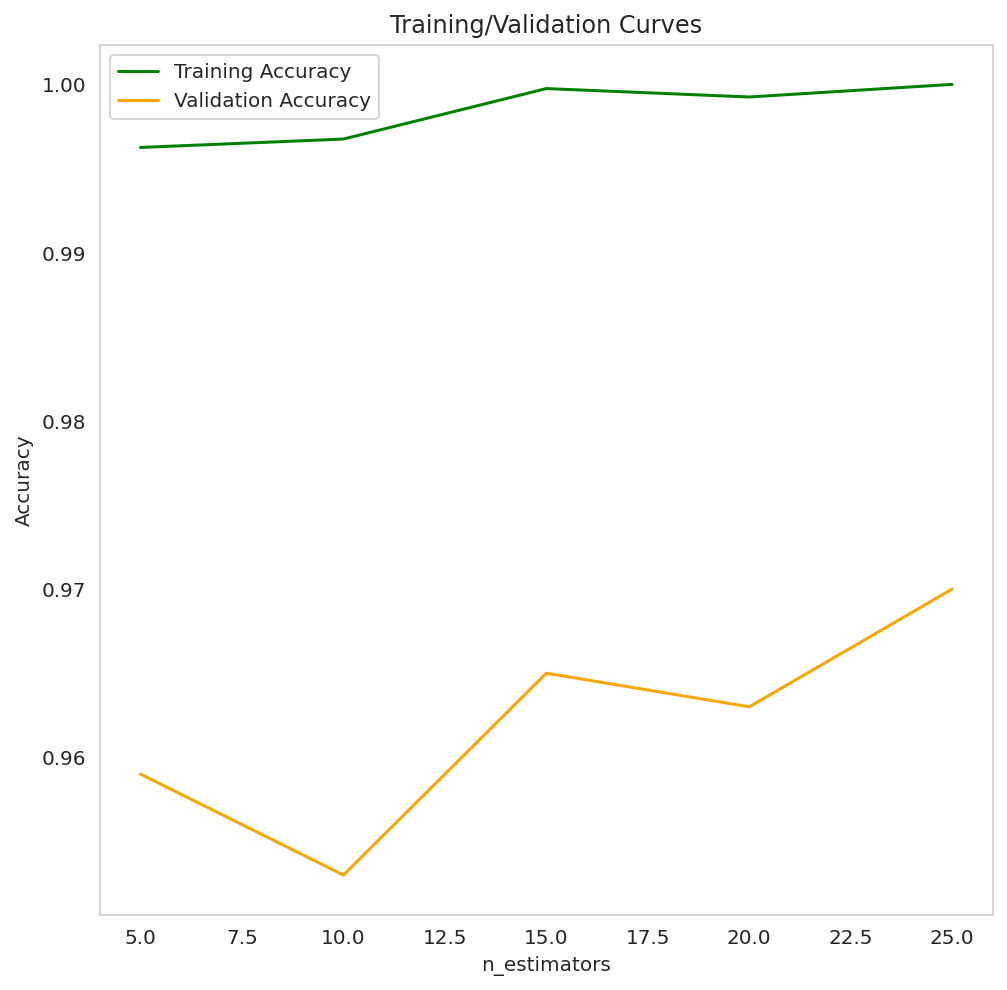


Average Train Accuracy for DT = 0.971
Average Train Accuracy for SVM = 1.0
Average Train Accuracy for KNN = 0.916
Average Train Accuracy for RF = 0.9946666666666667
Average Train Accuracy for ADA = 1.0
Average Train Accuracy for BAG = 1.0
Average Val Accuracy for DT = 0.911
Average Val Accuracy for SVM = 0.98
Average Val Accuracy for KNN = 0.868
Average Val Accuracy for RF = 0.9736666666666666
Average Val Accuracy for ADA = 0.996
Average Val Accuracy for BAG = 0.9676666666666666
Average Test Accuracy for DT = 0.8996666666666666
Average Test Accuracy for SVM = 0.961
Average Test Accuracy for KNN = 0.878
Average Test Accuracy for RF = 0.9536666666666666
Average Test Accuracy for ADA = 0.9553333333333333
Average Test Accuracy for BAG = 0.9436666666666667
Average F-Score for DT = 0.824
Average F-Score for SVM = 0.941
Average F-Score for KNN = 0.742
Average F-Score for RF = 0.9256666666666667
Average F-Score for ADA = 0.9256666666666667
Average F-Score for BAG = 0.908


In [96]:
#20/80 split

#prints out scores index: 
# 0-dtc train acc, 1-dtc val acc, 2-dtc test acc, 4-dtc fscore
# 5-svm train acc, 6-svm val acc, 7-svm test acc, 8-svm fscore
# 9-knn train acc, 10-knn val acc, 11-knn test acc, 12-knn fscore
# 13-rf train acc, 14-rf val acc, 15-rf test acc, 16-rf fscore
# 17-ada train acc, 18-ada val acc, 19-ada test acc, 20-ada fscore
# 21-bag train acc, 22-bag val acc, 23-bag test acc, 24-bag fscore

print("1st trial, 20/80 split:")
first_trial_scores = run_through_algorithms(f_2080[0],f_2080[1], f_2080[2], f_2080[3])
print()

print("2nd trial, 20/80 split:")
second_trial_scores = run_through_algorithms(s_2080[0],s_2080[1], s_2080[2], s_2080[3])
print()

print("3rd trial, 20/80 split:")
third_trial_scores = run_through_algorithms(t_2080[0],t_2080[1], t_2080[2], t_2080[3])
print()


train_acc_scores = [((first_trial_scores[i]+second_trial_scores[i]+third_trial_scores[i])/3) for i in range(24) if i%4==0]
val_acc_scores = [((first_trial_scores[i]+second_trial_scores[i]+third_trial_scores[i])/3) for i in range(24) if i%4==1]
test_acc_scores = [((first_trial_scores[i]+second_trial_scores[i]+third_trial_scores[i])/3) for i in range(24) if i%4==2]
fscores= [((first_trial_scores[i]+second_trial_scores[i]+third_trial_scores[i])/3) for i in range(24) if i%4==3]

train_acc_scores = [round(i,3) for i in train_acc_scores]
val_acc_scores = [round(i,3) for i in val_acc_scores]
test_acc_scores = [round(i,3) for i in test_acc_scores]
fscores = [round(i,3) for i in fscores]


train_acc_scores_list= [[first_trial_scores[i],second_trial_scores[i],third_trial_scores[i]] for i in range(24) if i%4==0]
val_acc_scores_list= [[first_trial_scores[i],second_trial_scores[i],third_trial_scores[i]] for i in range(24) if i%4==1]
test_acc_scores_list= [[first_trial_scores[i],second_trial_scores[i],third_trial_scores[i]] for i in range(24) if i%4==2]
fscores_list= [[first_trial_scores[i],second_trial_scores[i],third_trial_scores[i]] for i in range(24) if i%4==3]




df_2080

for i in range(6):
    print("Average Train Accuracy for {} = {}".format(names[i],train_acc_scores[i]))

for i in range(6):
    print("Average Val Accuracy for {} = {}".format(names[i],val_acc_scores[i]))
    
for i in range(6):
    print("Average Test Accuracy for {} = {}".format(names[i],test_acc_scores[i]))

for i in range(6):
    print("Average F-Score for {} = {}".format(names[i],fscores[i]))
    

In [97]:
df_2080 = pd.DataFrame({'Training 20_80 (3 trials)':train_acc_scores_list, 'Validation 20_80 (3 trials)':val_acc_scores_list,
                        'Testing 20_80 (3 trials)': test_acc_scores_list, 'fscores 20_80 (3 trials)': fscores_list})
df_2080.index = names
df_2080

,Training 20_80 (3 trials),Validation 20_80 (3 trials),Testing 20_80 (3 trials),fscores 20_80 (3 trials)
DT,"[0.971, 0.971, 0.971]","[0.917, 0.907, 0.909]","[0.901, 0.899, 0.899]","[0.825, 0.825, 0.822]"
SVM,"[1.0, 1.0, 1.0]","[0.98, 0.98, 0.98]","[0.961, 0.961, 0.961]","[0.941, 0.941, 0.941]"
KNN,"[0.916, 0.916, 0.916]","[0.868, 0.868, 0.868]","[0.878, 0.878, 0.878]","[0.742, 0.742, 0.742]"
RF,"[0.996, 0.996, 0.992]","[0.975, 0.974, 0.972]","[0.954, 0.953, 0.954]","[0.927, 0.924, 0.926]"
ADA,"[1.0, 1.0, 1.0]","[0.996, 0.996, 0.996]","[0.956, 0.956, 0.954]","[0.927, 0.927, 0.923]"
BAG,"[1.0, 1.0, 1.0]","[0.97, 0.963, 0.97]","[0.944, 0.944, 0.943]","[0.908, 0.908, 0.908]"


In [104]:
df_2080 = pd.DataFrame({'Training 20_80 (3 trials)':train_acc_scores_list, 'Validation 20_80 (3 trials)':val_acc_scores_list,
                        'Testing 20_80 (3 trials)': test_acc_scores_list, 'fscores 20_80 (3 trials)': fscores_list, 
                       'Avg Train Score':train_acc_scores, 'Avg Val Score':val_acc_scores, 
                        'Avg Test Score':test_acc_scores, 'Avg fscore': fscores})

df_2080.index = names
df_2080

,Training 20_80 (3 trials),Validation 20_80 (3 trials),Testing 20_80 (3 trials),fscores 20_80 (3 trials),Avg Train Score,Avg Val Score,Avg Test Score,Avg fscore
DT,"[0.971, 0.971, 0.971]","[0.917, 0.907, 0.909]","[0.901, 0.899, 0.899]","[0.825, 0.825, 0.822]",0.971000,0.911000,0.899667,0.824000
SVM,"[1.0, 1.0, 1.0]","[0.98, 0.98, 0.98]","[0.961, 0.961, 0.961]","[0.941, 0.941, 0.941]",1.000000,0.980000,0.961000,0.941000
KNN,"[0.916, 0.916, 0.916]","[0.868, 0.868, 0.868]","[0.878, 0.878, 0.878]","[0.742, 0.742, 0.742]",0.916000,0.868000,0.878000,0.742000
RF,"[0.996, 0.996, 0.992]","[0.975, 0.974, 0.972]","[0.954, 0.953, 0.954]","[0.927, 0.924, 0.926]",0.994667,0.973667,0.953667,0.925667
ADA,"[1.0, 1.0, 1.0]","[0.996, 0.996, 0.996]","[0.956, 0.956, 0.954]","[0.927, 0.927, 0.923]",1.000000,0.996000,0.955333,0.925667
BAG,"[1.0, 1.0, 1.0]","[0.97, 0.963, 0.97]","[0.944, 0.944, 0.943]","[0.908, 0.908, 0.908]",1.000000,0.967667,0.943667,0.908000
